# Importing Libraries

In [1]:
# libraries
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from bs4 import BeautifulSoup
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
import time
warnings.filterwarnings("ignore")

# Importing Datasets

The Kaggle competition provides a training dataset and a testing dataset to use. The datasets are made of real tweets, and will require pre-processing steps before any training step.

In [2]:
# Import Train Test set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

Printing Unique Keywords

In [4]:
keywords = set(train['keyword'].tolist())
print(keywords)

{nan, 'bioterror', 'hijacker', 'bridge%20collapse', 'arson', 'snowstorm', 'inundated', 'eyewitness', 'derailed', 'engulfed', 'injuries', 'violent%20storm', 'rubble', 'heat%20wave', 'weapon', 'flooding', 'screaming', 'buildings%20burning', 'siren', 'terrorist', 'traumatised', 'fire%20truck', 'devastated', 'lava', 'tragedy', 'blown%20up', 'desolate', 'seismic', 'trapped', 'body%20bag', 'devastation', 'hellfire', 'burning%20buildings', 'tsunami', 'structural%20failure', 'whirlwind', 'harm', 'storm', 'drowning', 'drought', 'fatality', 'massacre', 'inundation', 'bioterrorism', 'sinking', 'army', 'refugees', 'smoke', 'trouble', 'crush', 'death', 'sinkhole', 'wildfire', 'blight', 'rioting', 'airplane%20accident', 'fatalities', 'explosion', 'explode', 'forest%20fires', 'blew%20up', 'cliff%20fall', 'bleeding', 'rescue', 'avalanche', 'trauma', 'panicking', 'obliterated', 'floods', 'stretcher', 'wounds', 'emergency%20plan', 'wreckage', 'deluged', 'hazardous', 'chemical%20emergency', 'collapse', '

Dataset info

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Null counts for each feature in each dataset

In [7]:
# null count
print("Null counts for train dataset:")
print(train.isna().sum())
print("Null counts for test dataset:")
print(test.isna().sum())

Null counts for train dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null counts for test dataset:
id             0
keyword       26
location    1105
text           0
dtype: int64


Plotting Null counts by dataset

Text(0.5, 1.0, 'NaN Counts by Dataset')

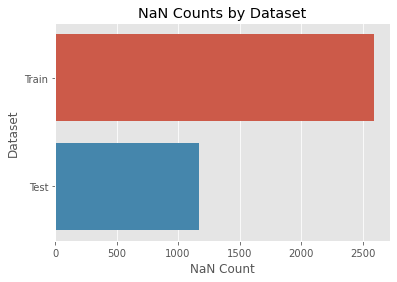

In [8]:
# plot null count by dataset
train_null_count = int(train['keyword'].isna().sum()) + int(train['location'].isna().sum())
test_null_count = int(train['keyword'].isna().sum()) + + int(test['location'].isna().sum())

nullcount = [["Train", train_null_count], ["Test", test_null_count]]
nulldf = pd.DataFrame(nullcount, columns = ["Dataset", "NaN Count"])

plt.style.use('ggplot')

sns.barplot(x='NaN Count', y='Dataset', data = nulldf)
plt.title('NaN Counts by Dataset')

Plotting Null counts by feature

Text(0.5, 1.0, 'NaN Counts by Feature')

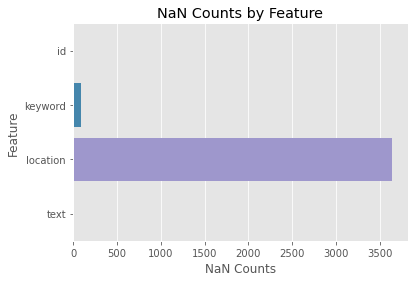

In [9]:
# count null values by feature
counts = []

for i in range(len(train.columns) - 1):
    counts.append(0)
for i in range(len(train.columns) - 1):
    counts[i] += train[train.columns[i]].isna().sum()
    counts[i] += test[test.columns[i]].isna().sum()

# build dataframe for nan counts
d = {"Feature": train.columns[:len(train.columns)-1], "NaN Counts": counts}
null_feat_df = pd.DataFrame(data=d)

# plotting 
plt.style.use('ggplot')
sns.barplot(x='NaN Counts', y='Feature', data = null_feat_df)
plt.title('NaN Counts by Feature')

Each tweet gets classified as a disaster tweet or not, which is represented as a binary value

Text(0.5, 1.0, 'Target Class Label Count')

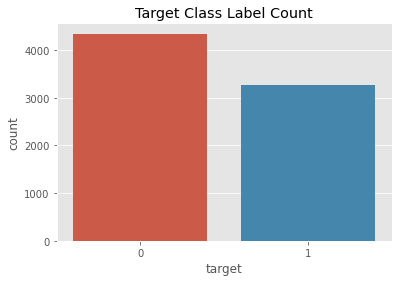

In [10]:
# plot target label count
plt.style.use('ggplot')

sns.countplot('target', data = train)
plt.title('Target Class Label Count')

A WordCould Image of the keywords feature. Bigger words represent higher occurance in the dataset

In [11]:
# generate wordcloud image of keywords
keys = train['keyword'].dropna().tolist()

for i in range(len(keys)):
    keys[i] = keys[i].replace("%20", ' ')
    
keys = ' '.join(keys)

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

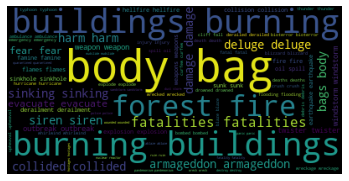

In [12]:
wordcloud = WordCloud().generate(keys)
plt.imshow(wordcloud)
plt.axis('off')
plt.imshow

Analyzing the stop word count

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# count stopwords in train/test
stopwords= stopwords.words('english')

train_text = train['text'].tolist()
test_text = test['text'].tolist()

tot_train_ctr = 0
tot_test_ctr = 0
train_ctr = 0
test_ctr = 0

for i in range(len(train_text)):
    words = train_text[i].split()
    for word in words:
        if word in stopwords:
            train_ctr += 1
        tot_train_ctr += 1
for i in range(len(test_text)):
    words = test_text[i].split()
    for word in words:
        if word in stopwords:
            test_ctr += 1
        tot_test_ctr += 1

# get the ratio of stop words to total words
print("Ratio of stop words in train set: ", train_ctr / tot_train_ctr)
print("Ratio of stop words in test set: ", test_ctr / tot_test_ctr)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ratio of stop words in train set:  0.25155780400313765
Ratio of stop words in test set:  0.2466005897771953


Approx. 25% of all words in both the training and test sets are made of stop words (irrelevant words). In order to create more accurate embeddings, we'll have to get rid of all the irrelevant words. This will greatly help for appraoches that use word embeddings/vectorization. 

# Pre-Processing

Helper Functions to apply on the text feature of the dataframe

First, a function to expand all contractions in text

In [14]:
import contractions # expands contractions (ex: I'll => I will)

In [15]:
def contraction_expand(df):
    return contractions.fix(df)

Next, a function to convert text to lower case

In [16]:
def lowercase_text(df):
    return df.lower()

A function to cast everything to a string type

In [17]:
def string_text(df):
    return str(df)

A function to remove twitter handles

In [18]:
def remove_user(df):
    return re.sub('@[^\s]+','', df)

A function to remove links

In [19]:
def remove_link(df):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , df)

A function to remove all emails

In [20]:
def remove_email(df):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", df)

A function to remove retweets

In [21]:
def remove_rt(df):
    return re.sub(r'\brt\b', "", df).strip()

A function to strip all text of leading and trailing white space

In [22]:
def strip_text(df):
    return df.strip()

A function to remove special characters

In [23]:
def remove_special_chars(df):
    df = re.sub(r'[^\w]+', " ", df)
    df = ' '.join(df.split())
    return df

A driver function to apply all the preprocessing steps at once onto a dataframe

In [24]:
def clean_data(df):
    df = string_text(df)
    df = contraction_expand(df)
    df = lowercase_text(df)
    df = remove_email(df)
    df = remove_link(df)
    df = remove_rt(df)
    df = remove_user(df)
    df = strip_text(df)
    return df

Apply the driver function onto the train and test sets

In [25]:
train['text'] = train['text'].apply(clean_data)
test['text'] = test['text'].apply(clean_data)
train['keyword'] = train['keyword'].apply(clean_data)
test['keyword'] = test['keyword'].apply(clean_data)

Apply the special characters function on the train and test set

In [26]:
train['text'] = train['text'].apply(remove_special_chars)
test['text'] = test['text'].apply(remove_special_chars)
train['keyword'] = train['keyword'].apply(remove_special_chars)
test['keyword'] = test['keyword'].apply(remove_special_chars)

Remove all digits from the train and test set

In [27]:
# Replacing digit characters with empty strings
train['text'] = train['text'].str.replace('\d+', '')
test['text'] = test['text'].str.replace('\d+', '')
train['keyword'] = train['keyword'].str.replace('\d+', '')
test['keyword'] = test['keyword'].str.replace('\d+', '')

Remove all stop words

In [28]:
# python module based of Numpy and Scipy for NLP preprocessing
from gensim.parsing.preprocessing import STOPWORDS
# handy function for removing stopwords
# simply have to apply this function to the dataset
from gensim.parsing.preprocessing import remove_stopwords

In [29]:
#remove stopwords from the train/test set
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

The id feature is irrelevant for this problem, so we can ignore it. The location feature contains the most amount of NaN values, so we can just ignore it. 

The keyword feature is a feature that indicates the most relevant word in the tweet. Basically it is the word that would indicate that a given tweet is a potential diaster tweet. There are a multiple ways to deal with this feature. The two ways I will try is first to ignore the keword feature entirely, and then to try and combine the keyword and text features (concatenate the keyword onto the tweet's text). It will be interesting to see how different the results will be, if at all. 


Merge keyword and text features into one content feature. We'll only merge keywords and text if the keyword is not a NaN. If it is, we don't need to do anything

In [30]:
train_content = train['text'].tolist()
test_content = test['text'].tolist()

train_keywords = train['keyword'].tolist()
test_keywords = test['keyword'].tolist()

for i in range(len(train_keywords)):
    if train_keywords[i] != "nan":
        train_content[i] = train_keywords[i] + " " + train_content[i]
    
for i in range(len(test_keywords)):
    if test_keywords[i] != "nan":
        test_content[i] = test_keywords[i] + " " + test_content[i]
    
train['content'] = train_content
test['content'] = test_content

### Word Embeddings

One common and effective approach to NLP classification problems is to create word embeddings. There are multiple ways to create word embeddings. The two ways I will use is the CountVectorizer and the TF-IDF Vectorizer. 

**Count Vectorizer** - A word embedding based on the counts of a specific word in a vocabulary for each text document. Produces a sparse matrix of token counts.


**vs.**


**TF-IDF Vectorizer** - Similar to the Count Vectorizer, it is a word embedding based on counts. But each word has a term frequency and a document frequency, so the new embeddings are created by multiplying the term frequency and the inverse of the document frequency. 



**Both vectorizers** are useful ways of creating a numbeical representation of text. The Count Vectorizer is inherently biased towards words that appear most frequently. This can be a problem, expecially in cases where the document size differs greatly. This issue is fized by the TF-IDF apprach, which which weights each count by the inverse of the occurances in the whole corpus. 

I think in this specific problem, we shouldn't expect to see a noticable difference when using either embedding, because Twitter puts a character limit on tweets. This means that documents in the corpus will not differ by a large amount. 

Both embeddings also produce a sparce matrix, which could limit the robustness of models.


Get the corpus data and target data

In [31]:
text_corpus = train['text']
content_corpus = train['content']
y = train['target']

Establish word embeddors from scikit learn. 

In [32]:
tfidf = TfidfVectorizer()
countVec = CountVectorizer()

### Vectorize the text corpus

In [33]:
X_text_tfidf = tfidf.fit_transform(text_corpus)
X_text_count = countVec.fit_transform(text_corpus)

# Testing on Various Baseline models - Text Corpus

**Logistic Regression** - Regression model based on estimating values using the Logit Function. It is a fast and flexible model that can perform binary classification tasks, and can work with Discrete and continuous data.

**Random Forest Classifier** - An ensemble learning model that uses multiple Decision Trees on various subsets of data to find the best classification. It is suitable for binary classification problems, can handle discrete and continuous data, and offers higher accuracy than the regular decision tree classifier. 

**Naive Bayes Algorithms** - A proabilistic model that is based off the Bayes theorem of conditional probability. It is very fast, and and offers great accuracy, especially in the context of Natural Language Processing, and text classification. It is also able to handle discrete and continuous data. 

In [34]:
# for computing accuracy of prediction 
from sklearn.metrics import accuracy_score

## Testing baseline models on the count vectorizer embedded data.

First - Train-Val-Split

In [35]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X_text_count, y, test_size=0.2, random_state=0)

### Logistic Regression 

Train and evaluate model

In [36]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

def LogReg(X_train, y_train, X_val, y_val):
    start_time = time.time()
    
    logreg_clf = LogisticRegression()
    logreg_clf.fit(X_train, y_train)
    y_pred = logreg_clf.predict(X_val)
    print("Logistic Regression [Count Vectorizer, Text Feature]\n")
    print(classification_report(y_val, y_pred))
    print("Execution Time:", time.time() - start_time, "seconds")
    return




Logistic Regression with Count Vectorizer and Text Feature

In [37]:
LogReg(X_train, y_train, X_val, y_val)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       886
           1       0.83      0.68      0.75       637

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Execution Time: 0.10870361328125 seconds


### Random Forest Classifier

Function to Train and Evaluate Model given train and validation sets

In [38]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

def RandomForest(X_train, y_train, X_val, y_val):
    

    start_time = time.time()

    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_val)
    print("Random Forest Classifier [Count Vectorizer, Text Feature]\n")
    print(classification_report(y_val, y_pred))
    print("Execution Time:", time.time() - start_time, "seconds")
    return 

Random Forest with Count Vectorizer and Text Feature

In [39]:
RandomForest(X_train, y_train, X_val, y_val)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       886
           1       0.81      0.64      0.71       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 13.370379447937012 seconds


### Naive Bayes Algorithms

Function to Train and Evaluate Model given train and validation sets

In [40]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB

Multinomial Naive Bayes Algorithm

In [41]:
def MultiNB(X_train, y_train, X_val, y_val):
    start_time = time.time()

    mnb_clf = MultinomialNB()
    mnb_clf.fit(X_train, y_train)
    y_pred = mnb_clf.predict(X_val)
    print("Multinomial Naive Bayes [Count Vectorizer, Text Feature]\n")
    print(classification_report(y_val, y_pred))
    print("Execution Time:", time.time() - start_time, "seconds")
    
    return
    

Gaussian Naive Bayes Algorithm

In [42]:
def GaussNB(X_train, y_train, X_val, y_val):
    start_time = time.time()

    gnb_clf = sklearn.naive_bayes.GaussianNB()
    gnb_clf.fit(X_train.toarray(), y_train)
    y_pred = gnb_clf.predict(X_val.toarray())
    print("Gaussian Naive Bayes [Count Vectorizer, Text Feature]\n")
    print(classification_report(y_val, y_pred))
    print("Execution Time:", time.time() - start_time, "seconds")
    
    return

Bernoulli Naive Bayes Algorithm

In [43]:
def BernNB(X_train, y_train, X_val, y_val):
    start_time = time.time()

    bnb_clf = sklearn.naive_bayes.BernoulliNB()
    bnb_clf.fit(X_train.toarray(), y_train)
    y_pred = bnb_clf.predict(X_val.toarray())
    print("Bernoulli Naive Bayes [Count Vectorizer, Text Feature]\n")
    print(classification_report(y_val, y_pred))
    print("Execution Time:", time.time() - start_time, "seconds")

Run the three naive bayes algorithms on the text feature embedded with the count vectorizer

In [44]:
MultiNB(X_train, y_train, X_val, y_val)

Multinomial Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       886
           1       0.77      0.72      0.75       637

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Execution Time: 0.005984067916870117 seconds


In [45]:
GaussNB(X_train, y_train, X_val, y_val)

Gaussian Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.48      0.59       886
           1       0.53      0.83      0.65       637

    accuracy                           0.62      1523
   macro avg       0.66      0.65      0.62      1523
weighted avg       0.68      0.62      0.62      1523

Execution Time: 1.3194622993469238 seconds


In [46]:
BernNB(X_train, y_train, X_val, y_val)

Bernoulli Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Execution Time: 1.7542462348937988 seconds


## Testing baseline models on the TF-IDF vectorizer embedded data.

Split the other embedded data

In [47]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X_text_tfidf, y, test_size=0.2, random_state=0)

Logistic Regression with the TF-IDF Vectorizer and the Text Feature

In [48]:
LogReg(X_train, y_train, X_val, y_val)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.93      0.84       886
           1       0.86      0.63      0.72       637

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523

Execution Time: 0.07380247116088867 seconds


Random Forest with the TF-IDF Vectorizer and the Text Feature

In [49]:
RandomForest(X_train, y_train, X_val, y_val)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       886
           1       0.82      0.63      0.71       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 12.500625610351562 seconds


Multinomial Naive Bayes with the TF-IDF Vectorizer and the Text Feature

In [50]:
MultiNB(X_train, y_train, X_val, y_val)

Multinomial Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       886
           1       0.81      0.66      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Execution Time: 0.005983829498291016 seconds


Gaussian Naive Bayes with the TF-IDF Vectorizer and the Text Feature

In [51]:
GaussNB(X_train, y_train, X_val, y_val)

Gaussian Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.76      0.50      0.61       886
           1       0.53      0.78      0.63       637

    accuracy                           0.62      1523
   macro avg       0.65      0.64      0.62      1523
weighted avg       0.67      0.62      0.62      1523

Execution Time: 1.2716219425201416 seconds


Bernoulli with the TF-IDF Vectorizer and the Text Feature

In [52]:
BernNB(X_train, y_train, X_val, y_val)

Bernoulli Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Execution Time: 0.8247623443603516 seconds


# Testing on Various Baseline models - Content Corpus

### Vectorize the Content Corpus

In [53]:
tfidf = TfidfVectorizer()
countVec = CountVectorizer()
X_content_tfidf = tfidf.fit_transform(content_corpus)
X_content_count = countVec.fit_transform(content_corpus)

## Testing baseline models on the count vectorizer embedded data.

In [54]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X_content_count, y, test_size=0.2, random_state=0)

Logistic Regression with the Count Vectorizer and the Content Feature

In [55]:
LogReg(X_train, y_train, X_val, y_val)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       886
           1       0.82      0.70      0.75       637

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Execution Time: 0.0937504768371582 seconds


Random Forest with the Count Vectorizer and the Content Feature

In [56]:
RandomForest(X_train, y_train, X_val, y_val)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       886
           1       0.81      0.63      0.71       637

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523

Execution Time: 12.473658323287964 seconds


Multinomial Naive Bayes with the Count Vectorizer and the Content Feature

In [57]:
MultiNB(X_train, y_train, X_val, y_val)

Multinomial Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       886
           1       0.76      0.72      0.74       637

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Execution Time: 0.004979133605957031 seconds


Gaussian Naive Bayes with the Count Vectorizer and the Content Feature

In [58]:
GaussNB(X_train, y_train, X_val, y_val)

Gaussian Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.48      0.60       886
           1       0.53      0.83      0.65       637

    accuracy                           0.62      1523
   macro avg       0.66      0.65      0.62      1523
weighted avg       0.68      0.62      0.62      1523

Execution Time: 1.3065366744995117 seconds


Bernoulli with the Count Vectorizer and the Content Feature

In [59]:
BernNB(X_train, y_train, X_val, y_val)

Bernoulli Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.65      0.72       637

    accuracy                           0.80      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Execution Time: 1.7723867893218994 seconds


## Testing baseline models on the TF-IDF vectorizer embedded data.

In [60]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X_content_tfidf, y, test_size=0.2, random_state=0)

Logistic Regression with the TF-IDF Vectorizer and the Content Feature

In [61]:
LogReg(X_train, y_train, X_val, y_val)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.65      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Execution Time: 0.06283164024353027 seconds


Random Forest Classifier with the TF-IDF Vectorizer and the Content Feature

In [62]:
RandomForest(X_train, y_train, X_val, y_val)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       886
           1       0.85      0.61      0.71       637

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.77      1523
weighted avg       0.80      0.79      0.78      1523

Execution Time: 12.244332075119019 seconds


Multinomial Naive Bayes with the TF-IDF Vectorizer and the Content Feature

In [63]:
MultiNB(X_train, y_train, X_val, y_val)

Multinomial Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       886
           1       0.80      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 0.0059854984283447266 seconds


Gaussian Naive Bayes with the TF-IDF Vectorizer and the Content Feature

In [64]:
GaussNB(X_train, y_train, X_val, y_val)

Gaussian Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.76      0.50      0.61       886
           1       0.53      0.78      0.63       637

    accuracy                           0.62      1523
   macro avg       0.65      0.64      0.62      1523
weighted avg       0.67      0.62      0.62      1523

Execution Time: 1.3344566822052002 seconds


Bernoulli Naive Bayes with the TF-IDF Vectorizer and the Content Feature

In [65]:
BernNB(X_train, y_train, X_val, y_val)

Bernoulli Naive Bayes [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.65      0.72       637

    accuracy                           0.80      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Execution Time: 0.7709736824035645 seconds


# Dimensionality Reduction

As mentioned above, both the CountVectorizer and the TF-IDF produce sparce matrices. In general sparce data is not good, as they indicate that there is missing information, and they are less memory efficient. 

One way I will attempt to solve this is with dimensionality reduction via Singular Value Decomposition (SVD). SVD will take a sparce matrix and prduce a denser lower dimensionality representation of the matrix. 

I will be using the TruncatedSVD from sklearn, which performs a linear dimensionality reduction via truncated singular value decomposition. In the docs, this works with both CountVectorizer and TFD-IDF Vectorizer matrices. Using the TruncatedSVD in the context of word vectorizers is known as Latent Semantic Analysis, or **LSA**

It is **not recommended** to use any Naive Bayes algorithm on the TruncatedSVD, because the algorithm applied Matrix Factorization. Since the Naive Bayes applied the bayes theorem with the naive assumption of strong independance between features, matrix factorization will not work with Naive Bayes. Thus, I will only use the Logistic Regression and Random Forest Classifier.   

For this section, I will use the TruncatedSVD on both Vectorizers, using the content feature that was created above. 

In [66]:
from sklearn.decomposition import TruncatedSVD

According to the docs, it is recommended to use an output dimensionality of 100 for LSA. First, I will use the defual of 2 to create a visualization of what the reduced dimensionality data looks like. 

### Visualizing Reduced Dimensionality Data

First, get the reduced CountVectorizer Data

In [67]:
svd = TruncatedSVD(n_components=2, random_state=42)
dense_count_2 = svd.fit_transform(X_content_count)

Plot the reduced data

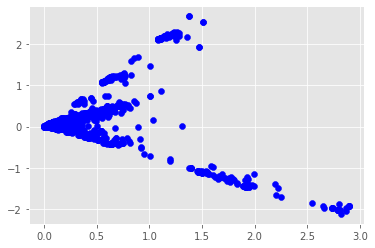

In [68]:
x1 = dense_count_2[:, 0]
y1 = dense_count_2[:, 1]

plt.scatter(x1, y1, c ="blue")
 
# To show the plot
plt.show()

Now let's get the reduced TF-IDF data

In [69]:
svd = TruncatedSVD(n_components=2, random_state=42)
dense_tfidf_2 = svd.fit_transform(X_content_tfidf)

Plot the data

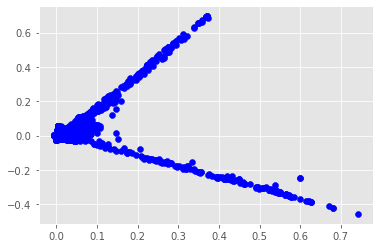

In [70]:
x1 = dense_tfidf_2[:, 0]
y1 = dense_tfidf_2[:, 1]

plt.scatter(x1, y1, c ="blue")
 
# To show the plot
plt.show()

These graphs show the affect of the TF-IDF principle of scaling each value by the inverse of the document frequency. There certainly seems to be less scatter among the points from the TF-IDF Vectorizer.

Now I'll use the recommended dimensionality of 100 to get the new data for each word embedding. After, I will re split the data and re-evaluate the models on the reduced data. 

### LSA Using TruncatedSVD

Reduce Dimensionality

In [71]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_dense_count = svd.fit_transform(X_content_count)
svd = TruncatedSVD(n_components=100, random_state=42)
X_dense_tfidf = svd.fit_transform(X_content_tfidf)

Split datasets

In [72]:
# Train Test Split

X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_dense_count, y, test_size=0.2, random_state=0)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_dense_tfidf, y, test_size=0.2, random_state=0)

Evaluate Models on Reduced Count Vectorizer data

In [73]:
LogReg(X_train_count, y_train_count, X_val_count, y_val_count)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.75      0.87      0.80       886
           1       0.76      0.59      0.66       637

    accuracy                           0.75      1523
   macro avg       0.75      0.73      0.73      1523
weighted avg       0.75      0.75      0.75      1523

Execution Time: 0.015958547592163086 seconds


In [74]:
RandomForest(X_train_count, y_train_count, X_val_count, y_val_count)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       886
           1       0.75      0.66      0.71       637

    accuracy                           0.77      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Execution Time: 2.8423025608062744 seconds


Evaluate Models of the dense TF-IDF Vectorizer data 

In [75]:
LogReg(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.74      0.88      0.81       886
           1       0.78      0.58      0.66       637

    accuracy                           0.76      1523
   macro avg       0.76      0.73      0.74      1523
weighted avg       0.76      0.76      0.75      1523

Execution Time: 0.019977092742919922 seconds


In [76]:
RandomForest(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       886
           1       0.79      0.67      0.73       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 2.8294637203216553 seconds


Compared to the results above, the SVD doesn't seem to have much positive impact on the accuracy score in this case. It does provide benefits to the execution time, particularly for the Random Forest Classifier.  

Let's redo the process with a few different target values for dimensionality reduction, and see how it affects the accuracy of the models. 

**LSA with a dimensionality of 50**

In [77]:
# get new reductions
svd = TruncatedSVD(n_components=50, random_state=42)
X_dense_count = svd.fit_transform(X_content_count)
svd = TruncatedSVD(n_components=50, random_state=42)
X_dense_tfidf = svd.fit_transform(X_content_tfidf)

# re-split the data
X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_dense_count, y, test_size=0.2, random_state=0)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_dense_tfidf, y, test_size=0.2, random_state=0)

Model Evaluations

In [78]:
LogReg(X_train_count, y_train_count, X_val_count, y_val_count)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       886
           1       0.76      0.52      0.62       637

    accuracy                           0.73      1523
   macro avg       0.74      0.70      0.71      1523
weighted avg       0.74      0.73      0.72      1523

Execution Time: 0.01296544075012207 seconds


In [79]:
RandomForest(X_train_count, y_train_count, X_val_count, y_val_count)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       886
           1       0.76      0.65      0.70       637

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Execution Time: 2.0076634883880615 seconds


In [80]:
LogReg(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       886
           1       0.80      0.47      0.59       637

    accuracy                           0.73      1523
   macro avg       0.75      0.69      0.70      1523
weighted avg       0.75      0.73      0.71      1523

Execution Time: 0.017951488494873047 seconds


In [81]:
RandomForest(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       886
           1       0.78      0.67      0.72       637

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Execution Time: 1.9647777080535889 seconds


**LSA with a dimensionality of 250**

In [82]:
# get new reductions
svd = TruncatedSVD(n_components=250, random_state=42)
X_dense_count = svd.fit_transform(X_content_count)
svd = TruncatedSVD(n_components=250, random_state=42)
X_dense_tfidf = svd.fit_transform(X_content_tfidf)

# re-split the data
X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_dense_count, y, test_size=0.2, random_state=0)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_dense_tfidf, y, test_size=0.2, random_state=0)

Model Evaluations

In [83]:
LogReg(X_train_count, y_train_count, X_val_count, y_val_count)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.87      0.83       886
           1       0.79      0.67      0.72       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 0.027958154678344727 seconds


In [84]:
RandomForest(X_train_count, y_train_count, X_val_count, y_val_count)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       886
           1       0.76      0.66      0.70       637

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.76      1523
weighted avg       0.77      0.77      0.76      1523

Execution Time: 4.758310794830322 seconds


In [85]:
LogReg(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       886
           1       0.78      0.64      0.70       637

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Execution Time: 0.03690075874328613 seconds


In [86]:
RandomForest(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.87      0.82       886
           1       0.78      0.67      0.72       637

    accuracy                           0.79      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 4.490027189254761 seconds


**LSA with a dimensionality of 500**

In [87]:
# get new reductions
svd = TruncatedSVD(n_components=500, random_state=42)
X_dense_count = svd.fit_transform(X_content_count)
svd = TruncatedSVD(n_components=500, random_state=42)
X_dense_tfidf = svd.fit_transform(X_content_tfidf)

# re-split the data
X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_dense_count, y, test_size=0.2, random_state=0)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_dense_tfidf, y, test_size=0.2, random_state=0)

Model Evaluations

In [88]:
LogReg(X_train_count, y_train_count, X_val_count, y_val_count)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       886
           1       0.79      0.67      0.73       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Execution Time: 0.0907895565032959 seconds


In [89]:
RandomForest(X_train_count, y_train_count, X_val_count, y_val_count)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       886
           1       0.77      0.67      0.72       637

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523

Execution Time: 6.775887966156006 seconds


In [90]:
LogReg(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       886
           1       0.81      0.64      0.71       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Execution Time: 0.07280421257019043 seconds


In [91]:
RandomForest(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       886
           1       0.79      0.65      0.71       637

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Execution Time: 6.735025882720947 seconds


**LSA with a dimensionality of 1000**

1000 dimensions is certainly not a small number of dimensions, but it is still an order of magnitude smaller than the 13K+ dimensions of the original vectorizers. Even larger datasets will have even higher orders of dimensions on the original vectorizers.

In [92]:
# get new reductions
svd = TruncatedSVD(n_components=1000, random_state=42)
X_dense_count = svd.fit_transform(X_content_count)
svd = TruncatedSVD(n_components=1000, random_state=42)
X_dense_tfidf = svd.fit_transform(X_content_tfidf)

# re-split the data
X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_dense_count, y, test_size=0.2, random_state=0)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_dense_tfidf, y, test_size=0.2, random_state=0)

Model Evaluations

In [93]:
LogReg(X_train_count, y_train_count, X_val_count, y_val_count)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       886
           1       0.81      0.68      0.74       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Execution Time: 0.23241209983825684 seconds


In [94]:
RandomForest(X_train_count, y_train_count, X_val_count, y_val_count)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       886
           1       0.75      0.64      0.69       637

    accuracy                           0.76      1523
   macro avg       0.76      0.74      0.75      1523
weighted avg       0.76      0.76      0.76      1523

Execution Time: 9.639333009719849 seconds


In [95]:
LogReg(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Logistic Regression [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       886
           1       0.82      0.64      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Execution Time: 0.2104332447052002 seconds


In [96]:
RandomForest(X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

Random Forest Classifier [Count Vectorizer, Text Feature]

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       886
           1       0.79      0.63      0.70       637

    accuracy                           0.77      1523
   macro avg       0.78      0.75      0.76      1523
weighted avg       0.78      0.77      0.77      1523

Execution Time: 9.907516479492188 seconds


Overall, the models seem to do better on the data with higher dimensions, but the execution time also increases. 

Interestingly, the Logistic Regression's performance was greater impacted by the number of dimensions. At just 50 dimensions, the model achieved an accuracy of approx. 73%, but at 1000 dimensions, the model achieved an accuracy of approx 80%. 

The Random Forest Classifier's accuracy score across all tests did not change nearly as much. The random forest classifier seems to perform better on the TF-IDF vectorizer data than the count vectorizer, but the difference is marginal. The target dimensionality of the SVD output also seems to play little role in the performance of the model. The biggest impact SVD has on the model was the execution time, with the 50 dimension data executing several times faster than the original 13K+ dimension data. 

# Conclusion 

My hope for this project was to explore various ways to tackle an NLP problem via different preprocessing methods, word embeddings and model selections. The problem of text classification is certainly not an easy problem to solve, but there exist a variety of ways to model this problem with math and various regression/classification algorithms.

There is more to explore in the realm of text classification. Currently, there exists deep learning models that are capable of solving this problem, using the same types of word embeddings used in this project. Some robust and popular choices are the Bidirectional-LSTM model for sentence classification, or the BERT model which is a bidirectional encoder that uses transfer learning to solve a variety of NLP tasks, including text classification. 

In the context of this problem, I decided againt using these models as Deep Learning models are often the slowest models. When dealing with potential disaster tweets, the idea is to make accurate predictions as fast as possible, so that emergency response time is minimized. With deep learning models, training often is a very slow process. 

Model choice aside, there also exist other ways to pre-process and embed the text data. One pre-processing technique that comes to mind that I didn't do in this specific project is auto-correct. Since this is real twitter data, there is certainly going to be typos, so auto-correcting words may be another step to more accurately represent the data. 

Doing this project led me to interesting observations about text classification problems, but there is still so much more to learn. 